<a href="https://colab.research.google.com/github/IliaFarzi/EEG_Sleep_Stage/blob/master/ViT_EEG_sleep_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: unzip /content/drive/MyDrive/AISContest_Data.zip to content

!unzip /content/drive/MyDrive/AISContest_Data.zip -d /content/data

# Formating data

In [4]:
import os
import random
import string
import pandas as pd

In [9]:
# Function to generate random 16-digit hexadecimal name
def generate_hex_name():
    return ''.join(random.choices(string.hexdigits[:16], k=16)).lower()

generate_hex_name()

'2599efc92a16402f'

In [14]:
# Define paths
input_dir = "/content/data/AISContest_Data"
output_dir = "/content/formated_data"
label_output_path = "/content/labels.csv"
file_extention = '.npy'
os.makedirs(output_dir, exist_ok=True)

# Define label mapping
label_mapping = {
    "0": "WAKE",
    "1": "NERM1",
    "2": "NERM2",
    "3": "NERM3",
    "4": "REM"
}

In [19]:
# Process each subfolder
csv_data = []
try:
  os.remove(label_output_path)
  os.rmdir(output_dir)
except:
  print('cleaningAssetsFailed')

for label, label_name in label_mapping.items():
    folder_path = os.path.join(input_dir, label)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.endswith(file_extention):
                # Generate new filename
                new_name = generate_hex_name() + file_extention

                # Define source and destination paths
                src_path = os.path.join(folder_path, file_name)
                dst_path = os.path.join(output_dir, new_name)

                # Move file
                os.rename(src_path, dst_path)

                # Add entry to CSV data
                csv_data.append({
                    "instance": new_name.replace(file_extention, ""),
                    "label": label,
                    "label_name": label_name
                })

# Create DataFrame and save as CSV
csv_df = pd.DataFrame(csv_data)
csv_df.to_csv(label_output_path, index=False)

print(f"Processing complete. Restructured data is in '{output_dir}'")

cleaningAssetsFailed
Processing complete. Restructured data is in '/content/formated_data'


In [20]:
df = pd.read_csv(label_output_path)
df.head()

,instance,label,label_name
0,8de82bbfb1c9b7ad,0,WAKE
1,8717f5f12c456a1b,0,WAKE
2,233ca43e56671e10,0,WAKE
3,c3b06ac1998fd603,0,WAKE
4,bc118fbec831f7c3,0,WAKE


# Saving to Drive

In [25]:
!mkdir -p /content/sleep-EEG-data
!cp -r /content/formated_data /content/sleep-EEG-data/
!cp /content/labels.csv /content/sleep-EEG-data/
!zip -r /content/sleep-EEG-data.zip /content/sleep-EEG-data
!cp /content/sleep-EEG-data.zip /content/drive/MyDrive/

# Loading Data

In [5]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import pandas as pd

In [6]:
# Define the label mapping
label_mapping = {
    "0": "WAKE",
    "1": "NERM1",
    "2": "NERM2",
    "3": "NERM3",
    "4": "REM"
}
# Load labels from the CSV file
labels_csv_path = "/content/sleep-EEG-data/labels.csv"
data_dir = "/content/sleep-EEG-data/formated_data"

In [7]:
def convert_labels_to_dic(labels_csv_path):
  """
  Convert labels from a CSV file into a dictionary.

  Returns:
      dict: A dictionary mapping file instances to labels.
  """
  labels_df = pd.read_csv(labels_csv_path)
  # Convert the labels DataFrame into a dictionary for quick lookup
  # Key: 'instance' (file name without extension), Value: 'label'
  labels_dict = dict(zip(labels_df['instance'], labels_df['label']))
  return labels_dict

In [8]:
labels_dict = convert_labels_to_dic(labels_csv_path)

In [9]:
# Function to load EEG data and match labels
def load_eeg_data_with_labels(data_dir, labels_dict):
    """
    Load EEG data and match them with labels from the labels dictionary.

    Args:
        data_dir (str): Path to the directory containing .npy files.
        labels_dict (dict): Dictionary mapping file instances to labels.

    Returns:
        data (numpy.ndarray): EEG data samples.
        labels (numpy.ndarray): Corresponding labels.
    """
    data = []
    labels = []

    # Iterate through all files in the directory
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.npy'):
            # Extract the instance name (filename without extension)
            instance_name = os.path.splitext(file_name)[0]

            # Check if the instance exists in the labels dictionary
            if instance_name in labels_dict:
                # Load the EEG sample
                file_path = os.path.join(data_dir, file_name)
                eeg_sample = np.load(file_path, allow_pickle=True)

                # Append data and label
                data.append(eeg_sample)
                labels.append(labels_dict[instance_name])
            else:
                print(f"Warning: No label found for {instance_name}")

    return np.array(data), np.array(labels)

In [10]:
# Load data and labels
data, labels = load_eeg_data_with_labels(data_dir, labels_dict)

# Map labels to label names (optional, for better interpretability)
label_names = [label_mapping[str(label)] for label in labels]

In [11]:
# Shuffle data
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [12]:
# Split data into training and testing sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.15, random_state=42)

In [13]:
# Print shapes to verify
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (4941, 51, 59, 1)
Testing data shape: (872, 51, 59, 1)
Training labels shape: (4941,)
Testing labels shape: (872,)


# EDA

In [28]:
import numpy as np
import matplotlib.pyplot as plt

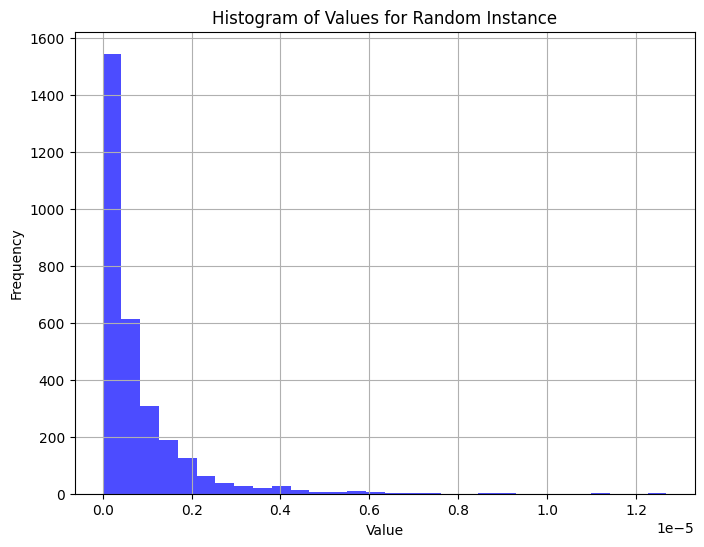

In [29]:
# a random instance value desterbution
random_index = np.random.randint(0, data.shape[0])
random_instance = data[0].squeeze()

# Flatten the instance to a 1D array
flattened_data = random_instance.flatten()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(flattened_data, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Values for Random Instance')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

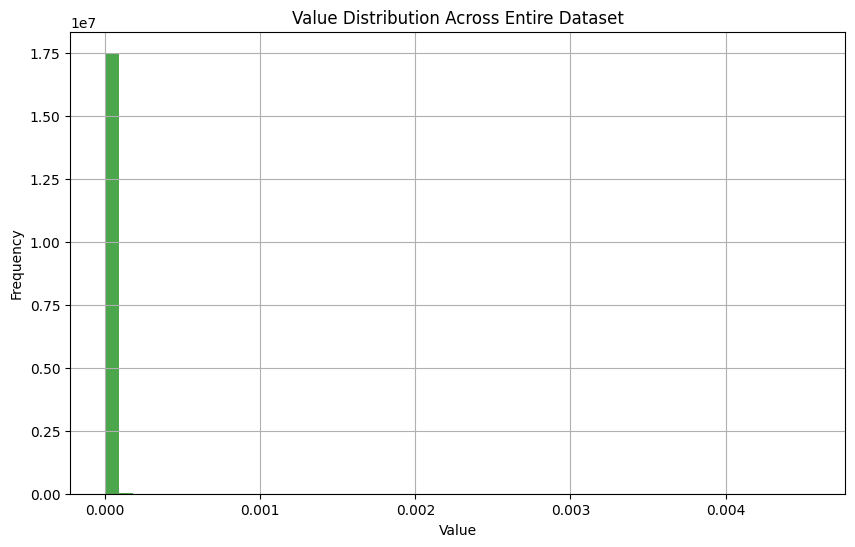

In [31]:
# all instances value desterbution

flattened_data = data.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, color='green', alpha=0.7)
plt.title('Value Distribution Across Entire Dataset')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Building a Trasformer

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [3]:
# Set parameters
NUM_CLASSES = 5
IMG_SIZE = (224, 224)  # Resize images to 224x224 for ViT
BATCH_SIZE = 32
EPOCHS = 10

In [32]:
# Preprocess data
def preprocess_data(X, y, img_size):
    """
    Preprocess EEG spectrogram data for transformer input.

    Args:
        X (numpy.ndarray): Input data (samples, 51, 59, 1).
        y (numpy.ndarray): Labels (samples,).
        img_size (tuple): Target image size (height, width).

    Returns:
        X_preprocessed, y_onehot: Resized and normalized data, and one-hot encoded labels.
    """
    # Resize images
    X_resized = tf.image.resize(X, img_size).numpy()
    # Normalize to range [0, 1]
    min_val = flattened_data.min()
    max_val = flattened_data.max()
    print(min_val, max_val)
    X_normalized = (X_resized - min_val) / (max_val - min_val)
    # One-hot encode labels
    y_onehot = tf.keras.utils.to_categorical(y, NUM_CLASSES)
    return X_normalized, y_onehot

In [33]:
X_train_preprocessed, y_train_preprocessed = preprocess_data(X_train, y_train, IMG_SIZE)
X_test_preprocessed, y_test_preprocessed = preprocess_data(X_test, y_test, IMG_SIZE)

7.778229078480061e-14 0.004543650045103833
7.778229078480061e-14 0.004543650045103833


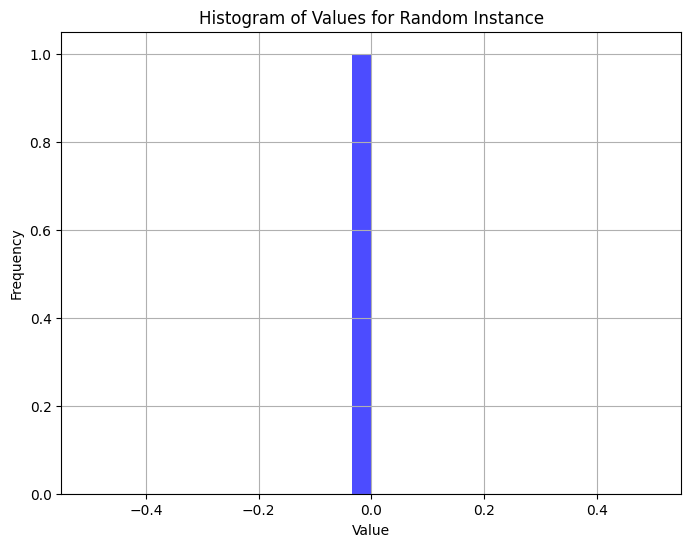

In [39]:
# a random instance value desterbution
random_index = np.random.randint(0, X_train_preprocessed.shape[0])
random_instance = X_train_preprocessed[0].squeeze()

# Flatten the instance to a 1D array
flattened_data = random_instance.flatten()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(flattened_data, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Values for Random Instance')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Load pre-trained ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=NUM_CLASSES
)

# Freeze pre-trained layers if desired
for layer in model.vit.encoder.layer[:-1]:
    layer.trainable = False

# Define optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_preprocessed,
    y_train_preprocessed,
    validation_data=(X_test_preprocessed, y_test_preprocessed),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_preprocessed, y_test_preprocessed)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the fine-tuned model
model.save_pretrained('./fine_tuned_vit')